# **Segmentación predictiva de clientes que cancelan tarjetas de crédito**

# **Equipo 8**


### Proyecto de fin de Módulo 4: Machine Learning

Septiembre - Octubre 2023

#### Integrantes:
- Efren Alejandro Jimenez Mukul
- Genesis Viridiana Varela Salinas
- Lizeth Marquez Quiroz
- Maricruz Conti del Castillo
- Miguel Augusto Ismerio Legarreta
- Victor Manuel Vera Arzate

#### **Problema:**

> Segmentar a los clientes de una compañía de tarjetas de crédito con cuatro modelos supervisados de clasificación (ML) para predecir qué cliente es más propenso a cancelar su tarjeta.


## **1. Data Wrangling** (obtención y limpieza de datos)

> #### **1.1** Importaciones

In [ ]:
!pip install opendatasets
!pip install lazypredict


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import opendatasets as od
import lightgbm as lgb

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import metrics
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, mean_squared_error, r2_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree as treeClassifier
from sklearn.ensemble import RandomForestClassifier
from lazypredict.Supervised import LazyRegressor, LazyClassifier

___

> #### **1.2** Carga del dataset desde Kaggle

In [ ]:
dataset_link="https://www.kaggle.com/datasets/thedevastator/predicting-credit-card-customer-attrition-with-m"

Para ejecutar esta parte del código debes tener cuenta en Kaggle y utilizar su api, (te brindan un username y un token)

**username:**       

mikeismerio

**kaggle key:**     

a4580838d36c5c8f03a12a439caed1f1

In [ ]:
od.download(dataset_link)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mikeismerio
Your Kaggle Key: ··········


100%|██████████| 379k/379k [00:00<00:00, 70.7MB/s]

In [ ]:
os.chdir("predicting-credit-card-customer-attrition-with-m")
os.listdir()

['BankChurners.csv']

In [ ]:
archivo = "BankChurners.csv"
df = pd.read_csv(archivo)

___

> #### **1.3** Dataframe original




In [ ]:
df.head()

CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
3  769911858  Existing Customer            40      F                4   
4  709106358  Existing Customer            40      M                3   

  Education_Level Marital_Status Income_Category Card_Category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School        Unknown  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   Months_on_book  ...  Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  \
0              39  ...      12691.00                  777         11914.00   
1              44  ...       8256.00                  864          7392.00   
2              36  ...       3418.00                    0          3418.00   
3              34  ...       3313.00                 2517           796.00   
4              21  ...       4716.00                    0          4716.00   

   Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  \
0                  1.33             1144              42                 1.62   
1                  1.54             1291              33                 3.71   
2                  2.59             1887              20                 2.33   
3                  1.41             1171              20                 2.33   
4                  2.17              816              28                 2.50   

   Avg_Utilization_Ratio  \
0                   0.06   
1                   0.10   
2                   0.00   
3                   0.76   
4                   0.00   

   Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1  \
0                                               0.00                                                                                    
1                                               0.00                                                                                    
2                                               0.00                                                                                    
3                                               0.00                                                                                    
4                                               0.00                                                                                    

   Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2  
0                                               1.00                                                                                   
1                                               1.00                                                                                   
2                                               1.00                                                                                   
3                                               1.00                                                                                   
4                                               1.00                                                                                   

[5 rows x 23 columns]

___

In [ ]:
df.shape

(10127, 23)

Tenemos un dataset con 10127 filas y 23 columnas

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                           

Las variables categoricas que tienen el datatype `object` se transformaran a numéricas más adelante. Además, notamos que todas las columnas estan completas, ie, no hay filas sin datos.

In [ ]:
df.drop(['CLIENTNUM',
        'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
         'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'
        ],
        axis=1).describe().transpose()

count    mean     std     min     25%     50%  \
Customer_Age             10127.00   46.33    8.02   26.00   41.00   46.00   
Dependent_count          10127.00    2.35    1.30    0.00    1.00    2.00   
Months_on_book           10127.00   35.93    7.99   13.00   31.00   36.00   
Total_Relationship_Count 10127.00    3.81    1.55    1.00    3.00    4.00   
Months_Inactive_12_mon   10127.00    2.34    1.01    0.00    2.00    2.00   
Contacts_Count_12_mon    10127.00    2.46    1.11    0.00    2.00    2.00   
Credit_Limit             10127.00 8631.95 9088.78 1438.30 2555.00 4549.00   
Total_Revolving_Bal      10127.00 1162.81  814.99    0.00  359.00 1276.00   
Avg_Open_To_Buy          10127.00 7469.14 9090.69    3.00 1324.50 3474.00   
Total_Amt_Chng_Q4_Q1     10127.00    0.76    0.22    0.00    0.63    0.74   
Total_Trans_Amt          10127.00 4404.09 3397.13  510.00 2155.50 3899.00   
Total_Trans_Ct           10127.00   64.86   23.47   10.00   45.00   67.00   
Total_Ct_Chng_Q4_Q1      10127.00    0.71    0.24    0.00    0.58    0.70   
Avg_Utilization_Ratio    10127.00    0.27    0.28    0.00    0.02    0.18   

                              75%      max  
Customer_Age                52.00    73.00  
Dependent_count              3.00     5.00  
Months_on_book              40.00    56.00  
Total_Relationship_Count     5.00     6.00  
Months_Inactive_12_mon       3.00     6.00  
Contacts_Count_12_mon        3.00     6.00  
Credit_Limit             11067.50 34516.00  
Total_Revolving_Bal       1784.00  2517.00  
Avg_Open_To_Buy           9859.00 34516.00  
Total_Amt_Chng_Q4_Q1         0.86     3.40  
Total_Trans_Amt           4741.00 18484.00  
Total_Trans_Ct              81.00   139.00  
Total_Ct_Chng_Q4_Q1          0.82     3.71  
Avg_Utilization_Ratio        0.50     1.00

Utilizamos describe para conocer como estan distribuidos nuestros datos

In [ ]:
df.isna().sum()

CLIENTNUM                                                                                                                             0
Attrition_Flag                                                                                                                        0
Customer_Age                                                                                                                          0
Gender                                                                                                                                0
Dependent_count                                                                                                                       0
Education_Level                                                                                                                       0
Marital_Status                                                                                                                        0
Income_Category                                 

No tenemos valores nulos (NaNs)

In [ ]:
df.CLIENTNUM.duplicated().sum()

0

Tampoco tenemos clientes repetidos (duplicados). Por tanto existen 10127 clientes en el dataset.

> #### **1.4** Eliminación de columnas innecesarias

In [ ]:
df_filtered = df.drop(columns=[
    'CLIENTNUM',
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'
])

## **2. Análisis Exploratorio de Datos** (EDA, por sus siglas en inglés)

El siguiente análisis exploratorio de datos se enfocará en comprender las columnas existentes en el dataset divididas por `Attrition_Flag` (que es justo la variable de interés para los modelos de ML)

> ### **2.1** Histogramas y boxplots

In [ ]:
# Agrupar por 'Attrition_Flag' y contar el número de clientes en cada grupo
grouped = df_filtered.groupby(['Attrition_Flag']).size().reset_index(name='clientes')

# Calcular el total de clientes
total_clientes = grouped['clientes'].sum()

# Calcular el porcentaje de cada grupo
grouped['porcentaje'] = (grouped['clientes'] / total_clientes) * 100

# Mostrar el resultado
print('Total', total_clientes)
grouped

Total 10127


Attrition_Flag  clientes  porcentaje
0  Attrited Customer      1627       16.07
1  Existing Customer      8500       83.93

Del total de 10127 clientes, solo un 16.1% a abandonado el banco.

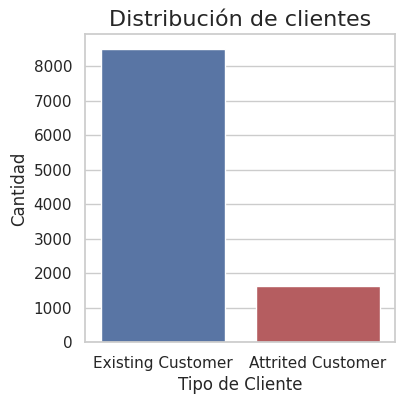

In [ ]:
# Datos de ejemplo
data = df_filtered['Attrition_Flag'].value_counts().reset_index()
data.columns = ['Attrition_Flag', 'Count']

# Configuración de estilo de Seaborn
sns.set(style="whitegrid")

# Crear el gráfico de barras con Seaborn
plt.figure(figsize=(4, 4))
sns.barplot(x='Attrition_Flag', y='Count', data=data, palette=['b', 'r'])
plt.title('Distribución de clientes', fontsize=16)
plt.xlabel('Tipo de Cliente')
plt.ylabel('Cantidad')

# Mostrar el gráfico
plt.show()

De los cuales,

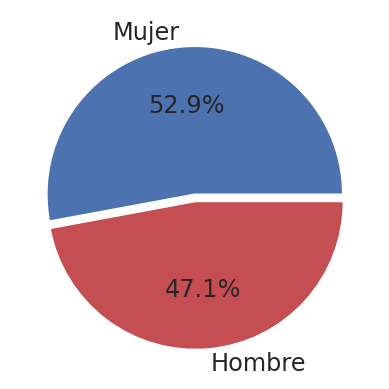

In [ ]:
plt.pie(df.groupby(['Gender']).size(), labels=['Mujer', 'Hombre'], explode=(0, 0.05), autopct='%.1f%%',
        textprops={'size': 'x-large'}, colors=['b', 'r'])
plt.show()

In [ ]:
df.groupby(['Gender', 'Attrition_Flag']).size().unstack(0)

Gender                F     M
Attrition_Flag               
Attrited Customer   930   697
Existing Customer  4428  4072

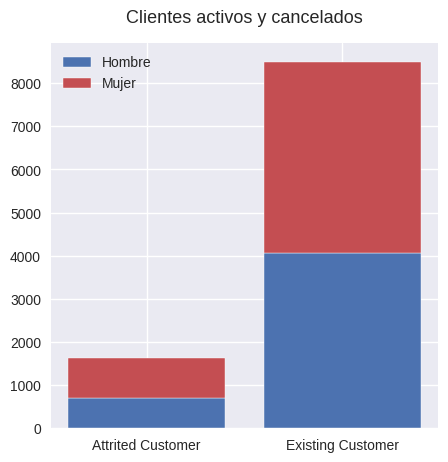

In [ ]:
vc = df.groupby(['Gender', 'Attrition_Flag']).size().unstack(0)

plt.style.use('seaborn')

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

plt1 = ax.bar(vc.index, vc['M'], label='Hombres', color='b')
plt2 = ax.bar(vc.index, vc['F'], bottom=vc['M'], label='Mujeres', color='r')

#ax.set_ylabel('count')
ax.set_title('Clientes activos y cancelados', fontsize=13, pad=15);
plt.legend((plt1[0], plt2[0]), ('Hombre', 'Mujer'));

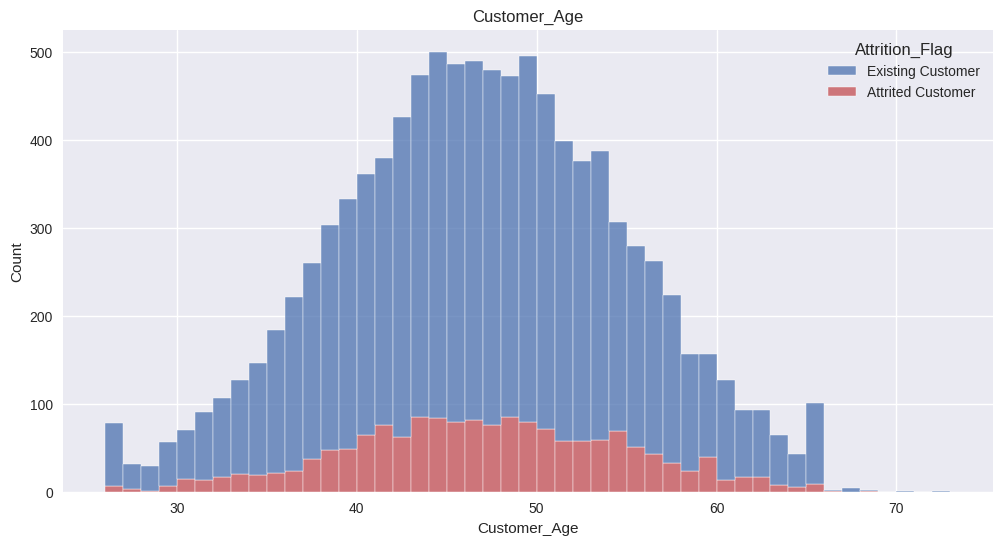

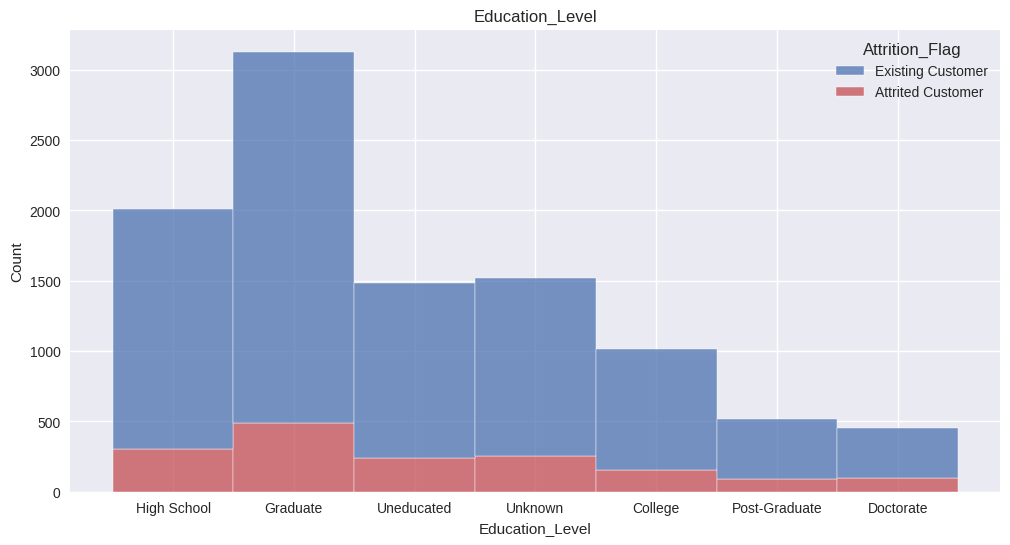

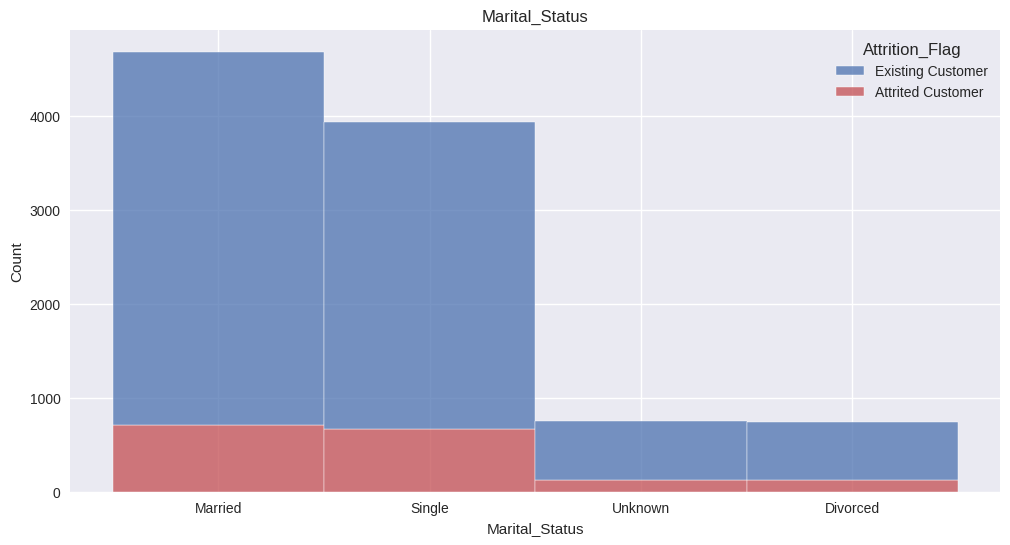

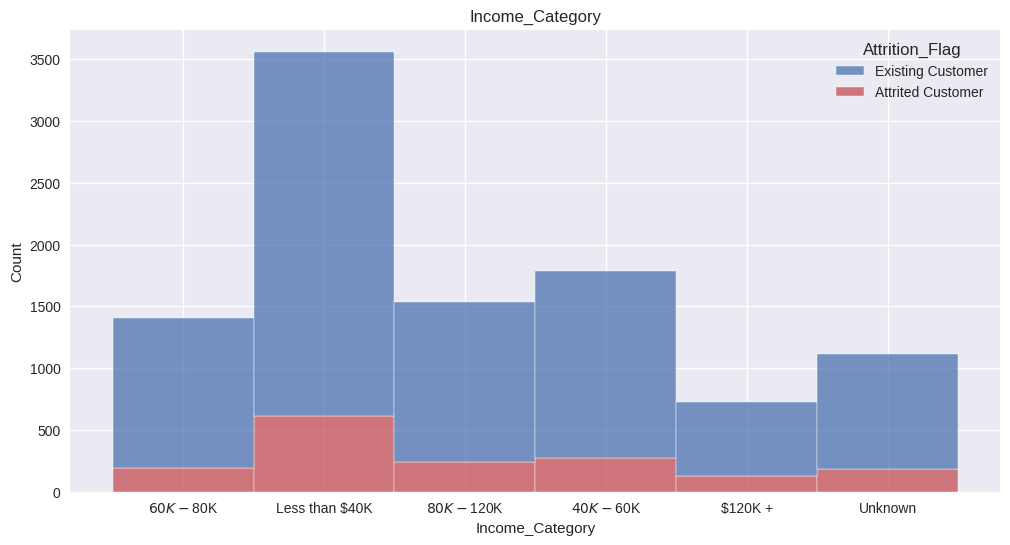

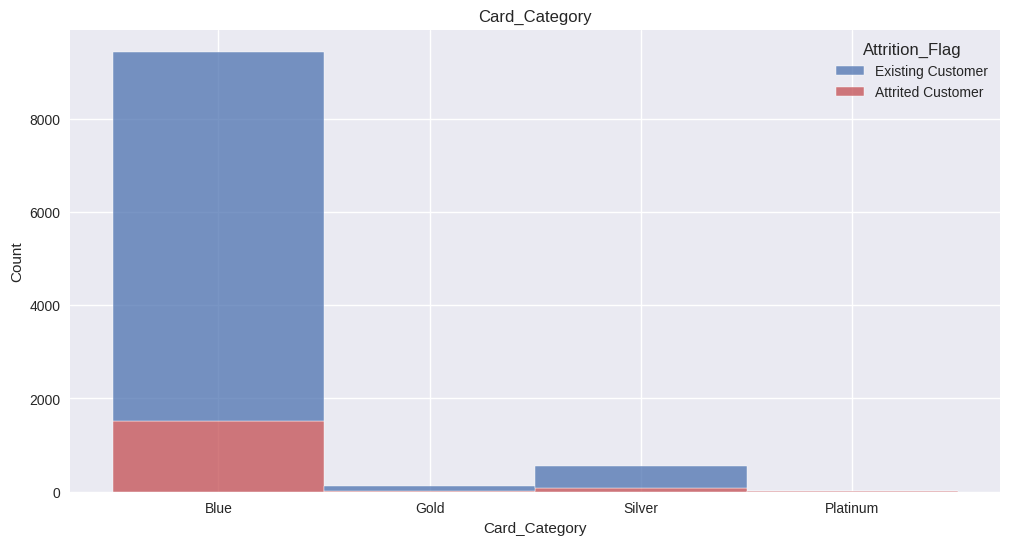

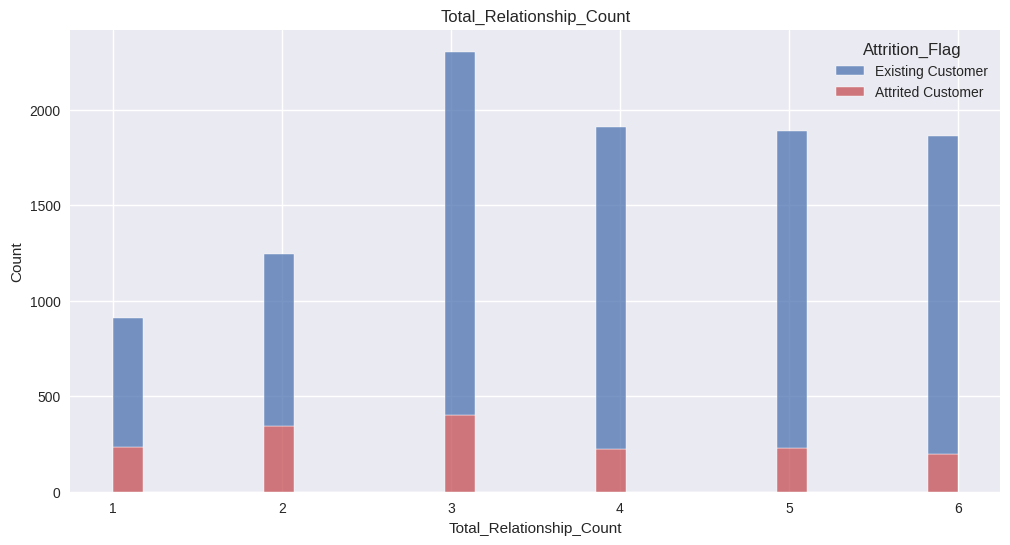

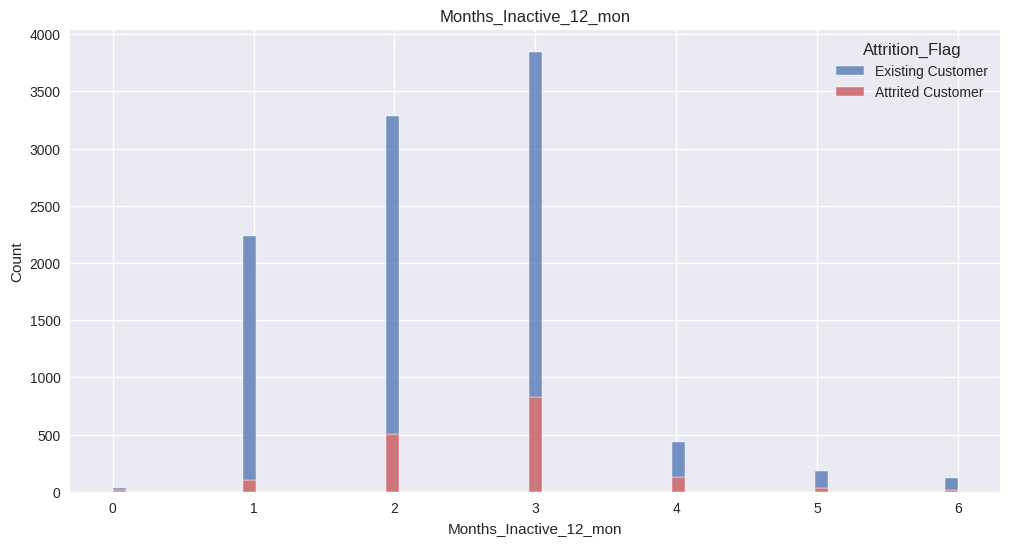

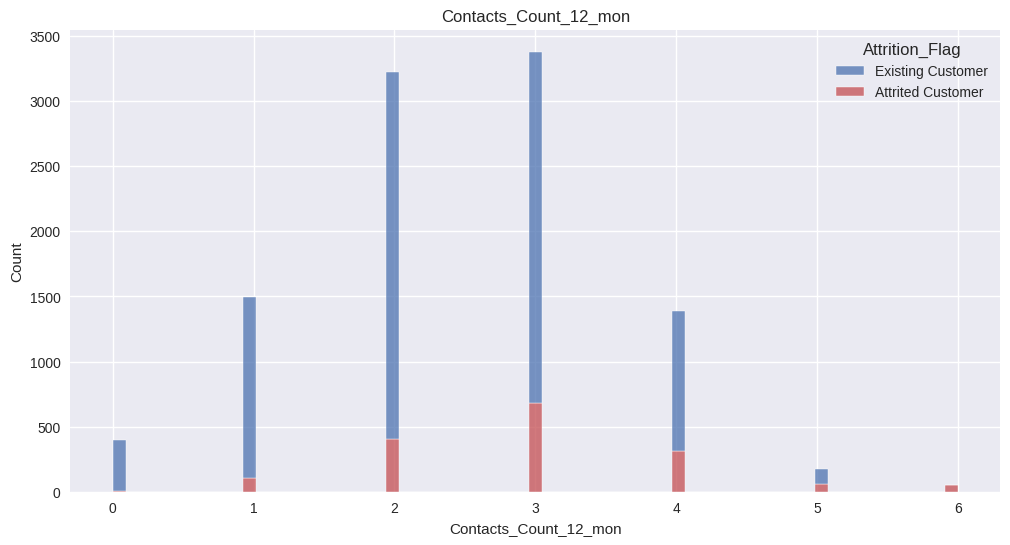

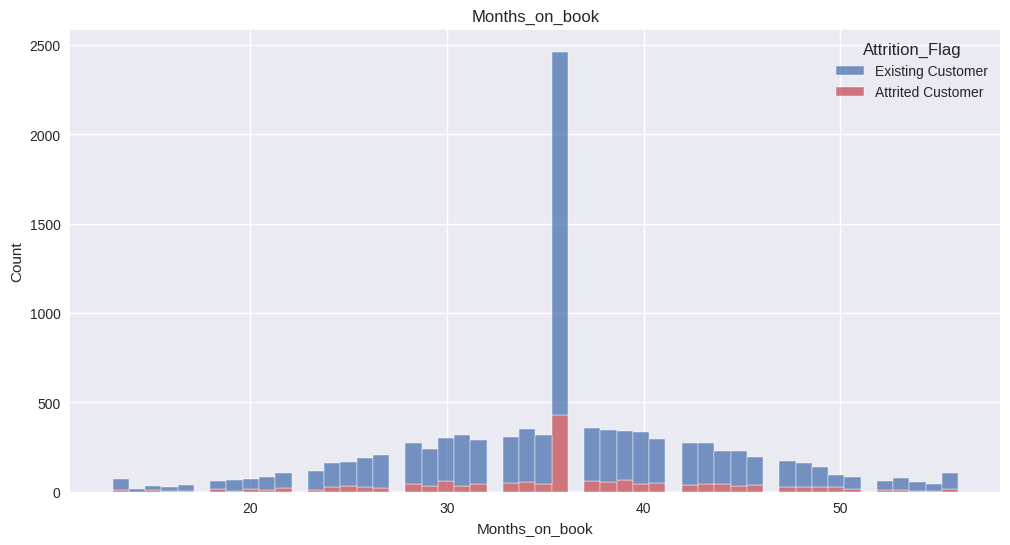

In [ ]:
features = ['Customer_Age','Education_Level', 'Marital_Status',
            'Income_Category', 'Card_Category',
            'Total_Relationship_Count', 'Months_Inactive_12_mon',
            'Contacts_Count_12_mon','Months_on_book']

for feature in features:
    #Plotting a countplot with subcategories
    plt.subplots(figsize=(12, 6))
    sns.histplot(data=df, x=feature, palette=['b', 'r'], hue='Attrition_Flag', multiple='stack')
    plt.title(feature)
    #plt.xticks(rotation=30)
    plt.show()
    plt.close()

- La edad de nuestros clientes tiende a una distribución gaussiana (ie, normal)
- La mayoría de nuestros clientes tienen estudios de licenciatura o superior. Otro porcentaje no tiene estudios o es desconocido para el banco.
- Una gran población de clientes es casado o soltero.
- Alrededor de 3500 clientes ganan menos de 40K.
- una gran mayoría tiene la tarjeta tipo Blue
- Nuestros clientes tienen de 1 a 6 servicios contratados, siendo 3 la cantidad promedio.
- Por lo general las personas que cancelan su tarjeta de crédito tienen de 1 a 3 meses de inactividad.
- Los clientes contactan al banco de 0 a 6 veces, y estos contactos podrían estar relacionados con la decisión de abandonar el banco.
- Notamos que la gran mayoría de nuestros clientes tiene más de 3 años con nosotros, pero a su vez, este valor está relacionado con la mayoría de casos de cancelación de tarjeta.


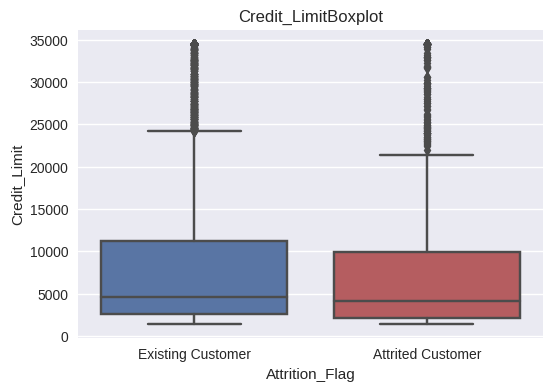

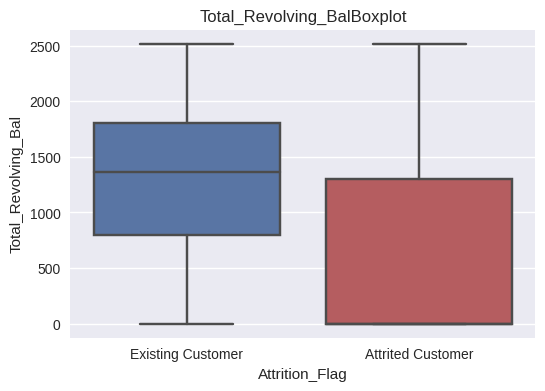

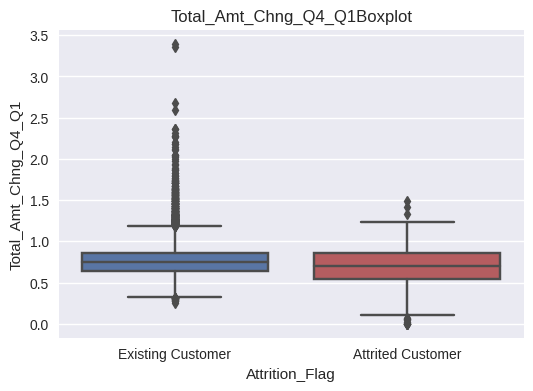

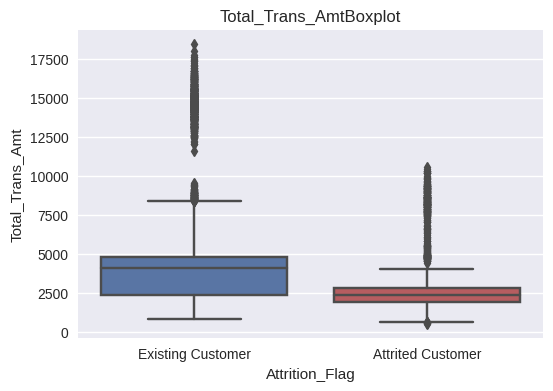

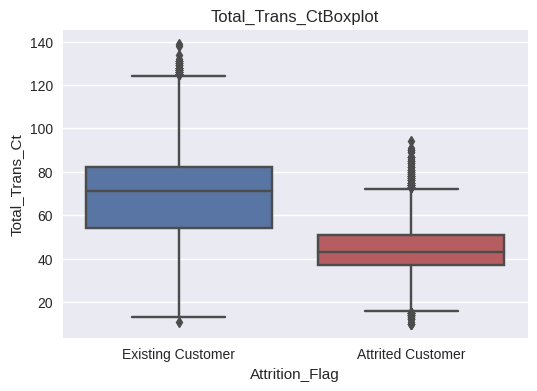

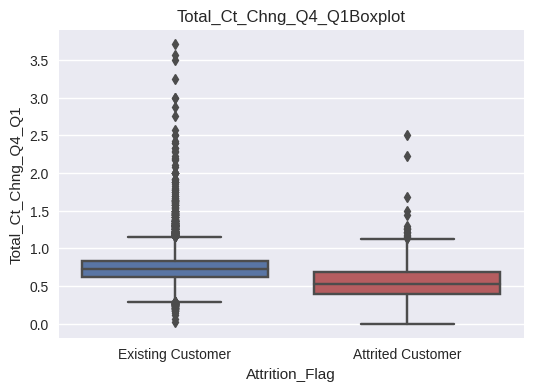

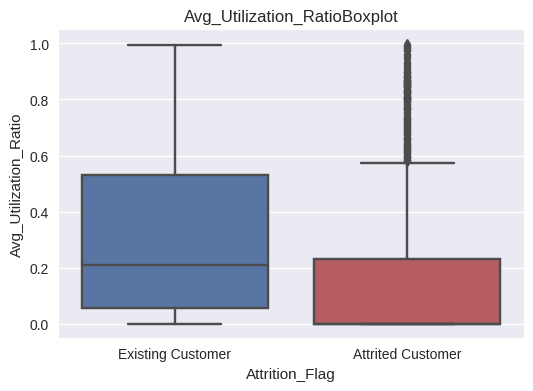

In [ ]:
for feature in ["Credit_Limit", "Total_Revolving_Bal", "Total_Amt_Chng_Q4_Q1",
                "Total_Trans_Amt", "Total_Trans_Ct", "Total_Ct_Chng_Q4_Q1",
               "Avg_Utilization_Ratio"]:
    plt.subplots(figsize=(6, 4))
    sns.boxplot(x = "Attrition_Flag", y = feature, data = df, palette=['b', 'r'])
    plt.title(feature +'Boxplot')
    plt.show()
    plt.close()

- Los clientes vigentes tienen límites de crédito mayores que los que abandonaron. Hay puntos atípicos en esta relación. Además, la mediana en ambos casos está por debajo de los 5000 $.
- Existe una diferencia clara en el saldo renovable total de los clientes. Es probable que esta sea una variable importante para los modelos.
- La razón de cantidades por trimestres tiene ligeras diferencias, los valores obtenidos de los clientes que abandonaron están bien definidos y dentro de su rango intercuartílico.
- El monto total de transacciones es mucho mayor en los clientes existentes (como es de esperarse). Esta variable igual puede ser de impacto para los modelos.
- El número total de transacciones también muestra cambios significativos.
- La razón de cambio por trimestre tiene aspectos similares a la antes mencionada.
- Por último, la razón de uso de tarjeta indica claramente que los clientes existentes en promedio usan más las tarjetas que los que ya abandonaron.


In [ ]:
value_counts_4 = df.groupby(['Gender','Income_Category']).size().unstack(0)
value_counts_4

Gender                F       M
Income_Category                
$120K +             NaN  727.00
$40K - $60K     1014.00  776.00
$60K - $80K         NaN 1402.00
$80K - $120K        NaN 1535.00
Less than $40K  3284.00  277.00
Unknown         1060.00   52.00

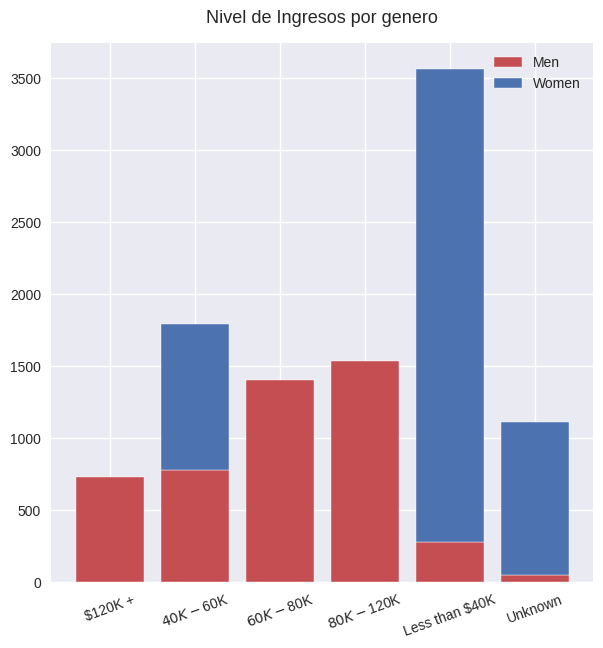

In [ ]:
plt.style.use('seaborn')

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot()

plt1 = ax.bar(value_counts_4.index, value_counts_4['M'], label='M', color='r')
plt2 = ax.bar(value_counts_4.index, value_counts_4['F'], bottom=value_counts_4['M'], color='b')

ax.tick_params(axis='x', labelrotation=20)
ax.set_title('Nivel de Ingresos por genero', fontsize=13, pad=15)
plt.legend((plt1[0], plt2[0]), ('Men', 'Women'))


Como dato interesante, se encontró una disparidad del nivel de ingresos de los clientes por género. Las mujeres registraron ingresos menores a 60K, mientras que los hombres tienen ingresos por arriba de los 120K.

> ### **2.2** Matriz de correlación

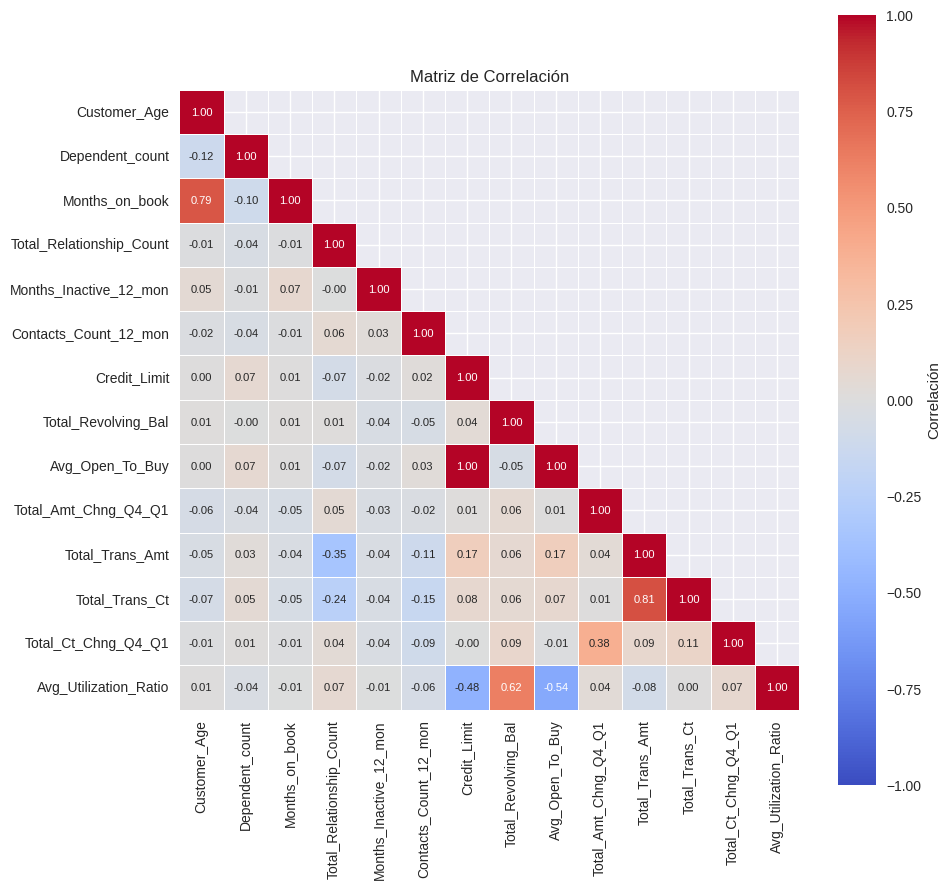

In [ ]:
# Calcular la matriz de correlación
corr_matrix = df_filtered.corr(numeric_only=True)

# Configurar el tamaño de la figura
plt.figure(figsize=(10, 10))

# Crear una máscara triangular
mask = np.tri(*corr_matrix.shape, k=-1).T

# Crear un heatmap (mapa de calor)
ax = sns.heatmap(
    corr_matrix,
    vmin=-1,
    vmax=1,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    mask=mask,
    linewidths=0.5,
    square=True,
    cbar_kws={'label': 'Correlación'},
    annot_kws={'size': 8}
)

# Configurar título del gráfico
ax.set_title('Matriz de Correlación')

# Mostrar el gráfico
plt.show()

- Existe una relación entre la edad del cliente y los meses que ha estado en el banco.
- El límite de crédito y el saldo disponible para gastar tiene una relación lineal.
- El uso promedio de la tarjeta está relacionado con el límite de crédito, el saldo disponible para gastar y el saldo renovable.
- El monto y número total de transacciones tiene también una relación lineal.
- También se encontró que hay relación entre las dos variables pertenecientes a los cambios entre trimestres.


> ### **2.3** Transformar variables categóricas a numéricas

(Se utiliza el método `.replace` para tener un control sobre el orden de cada categoría)

In [ ]:
df_filtered['Attrition_Flag'].replace(
    ['Attrited Customer', 'Existing Customer'],
    [0, 1],
    inplace=True)

df_filtered['Gender'].replace(
    ['F', 'M'],
    [0, 1],
    inplace=True)

df_filtered['Education_Level'].replace(
    ['Unknown', 'Uneducated', 'High School', 'College', 'Graduate', 'Post-Graduate', 'Doctorate'],
    [0, 1, 2, 3, 4, 5, 6],
    inplace=True)

df_filtered['Marital_Status'].replace(
    ['Unknown', 'Single', 'Married', 'Divorced'],
    [0, 1, 2, 3],
    inplace=True)

df_filtered['Income_Category'].replace({
    'Unknown': 0,
    'Less than $40K': 1,
    '$40K - $60K': 2,
    '$60K - $80K': 3,
    '$80K - $120K': 4,
    '$120K +': 5
}, inplace=True)

df_filtered['Card_Category'].replace(
    ['Blue', 'Silver', 'Gold', 'Platinum'],
    [0, 1, 2, 3],
    inplace=True)

In [ ]:
df_filtered.head()

Attrition_Flag  Customer_Age  Gender  Dependent_count  Education_Level  \
0               1            45       1                3                2   
1               1            49       0                5                4   
2               1            51       1                3                4   
3               1            40       0                4                2   
4               1            40       1                3                1   

   Marital_Status  Income_Category  Card_Category  Months_on_book  \
0               2                3              0              39   
1               1                1              0              44   
2               2                4              0              36   
3               0                1              0              34   
4               2                3              0              21   

   Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
0                         5                       1                      3   
1                         6                       1                      2   
2                         4                       1                      0   
3                         3                       4                      1   
4                         5                       1                      0   

   Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
0      12691.00                  777         11914.00                  1.33   
1       8256.00                  864          7392.00                  1.54   
2       3418.00                    0          3418.00                  2.59   
3       3313.00                 2517           796.00                  1.41   
4       4716.00                    0          4716.00                  2.17   

   Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
0             1144              42                 1.62                   0.06  
1             1291              33                 3.71                   0.10  
2             1887              20                 2.33                   0.00  
3             1171              20                 2.33                   0.76  
4              816              28                 2.50                   0.00

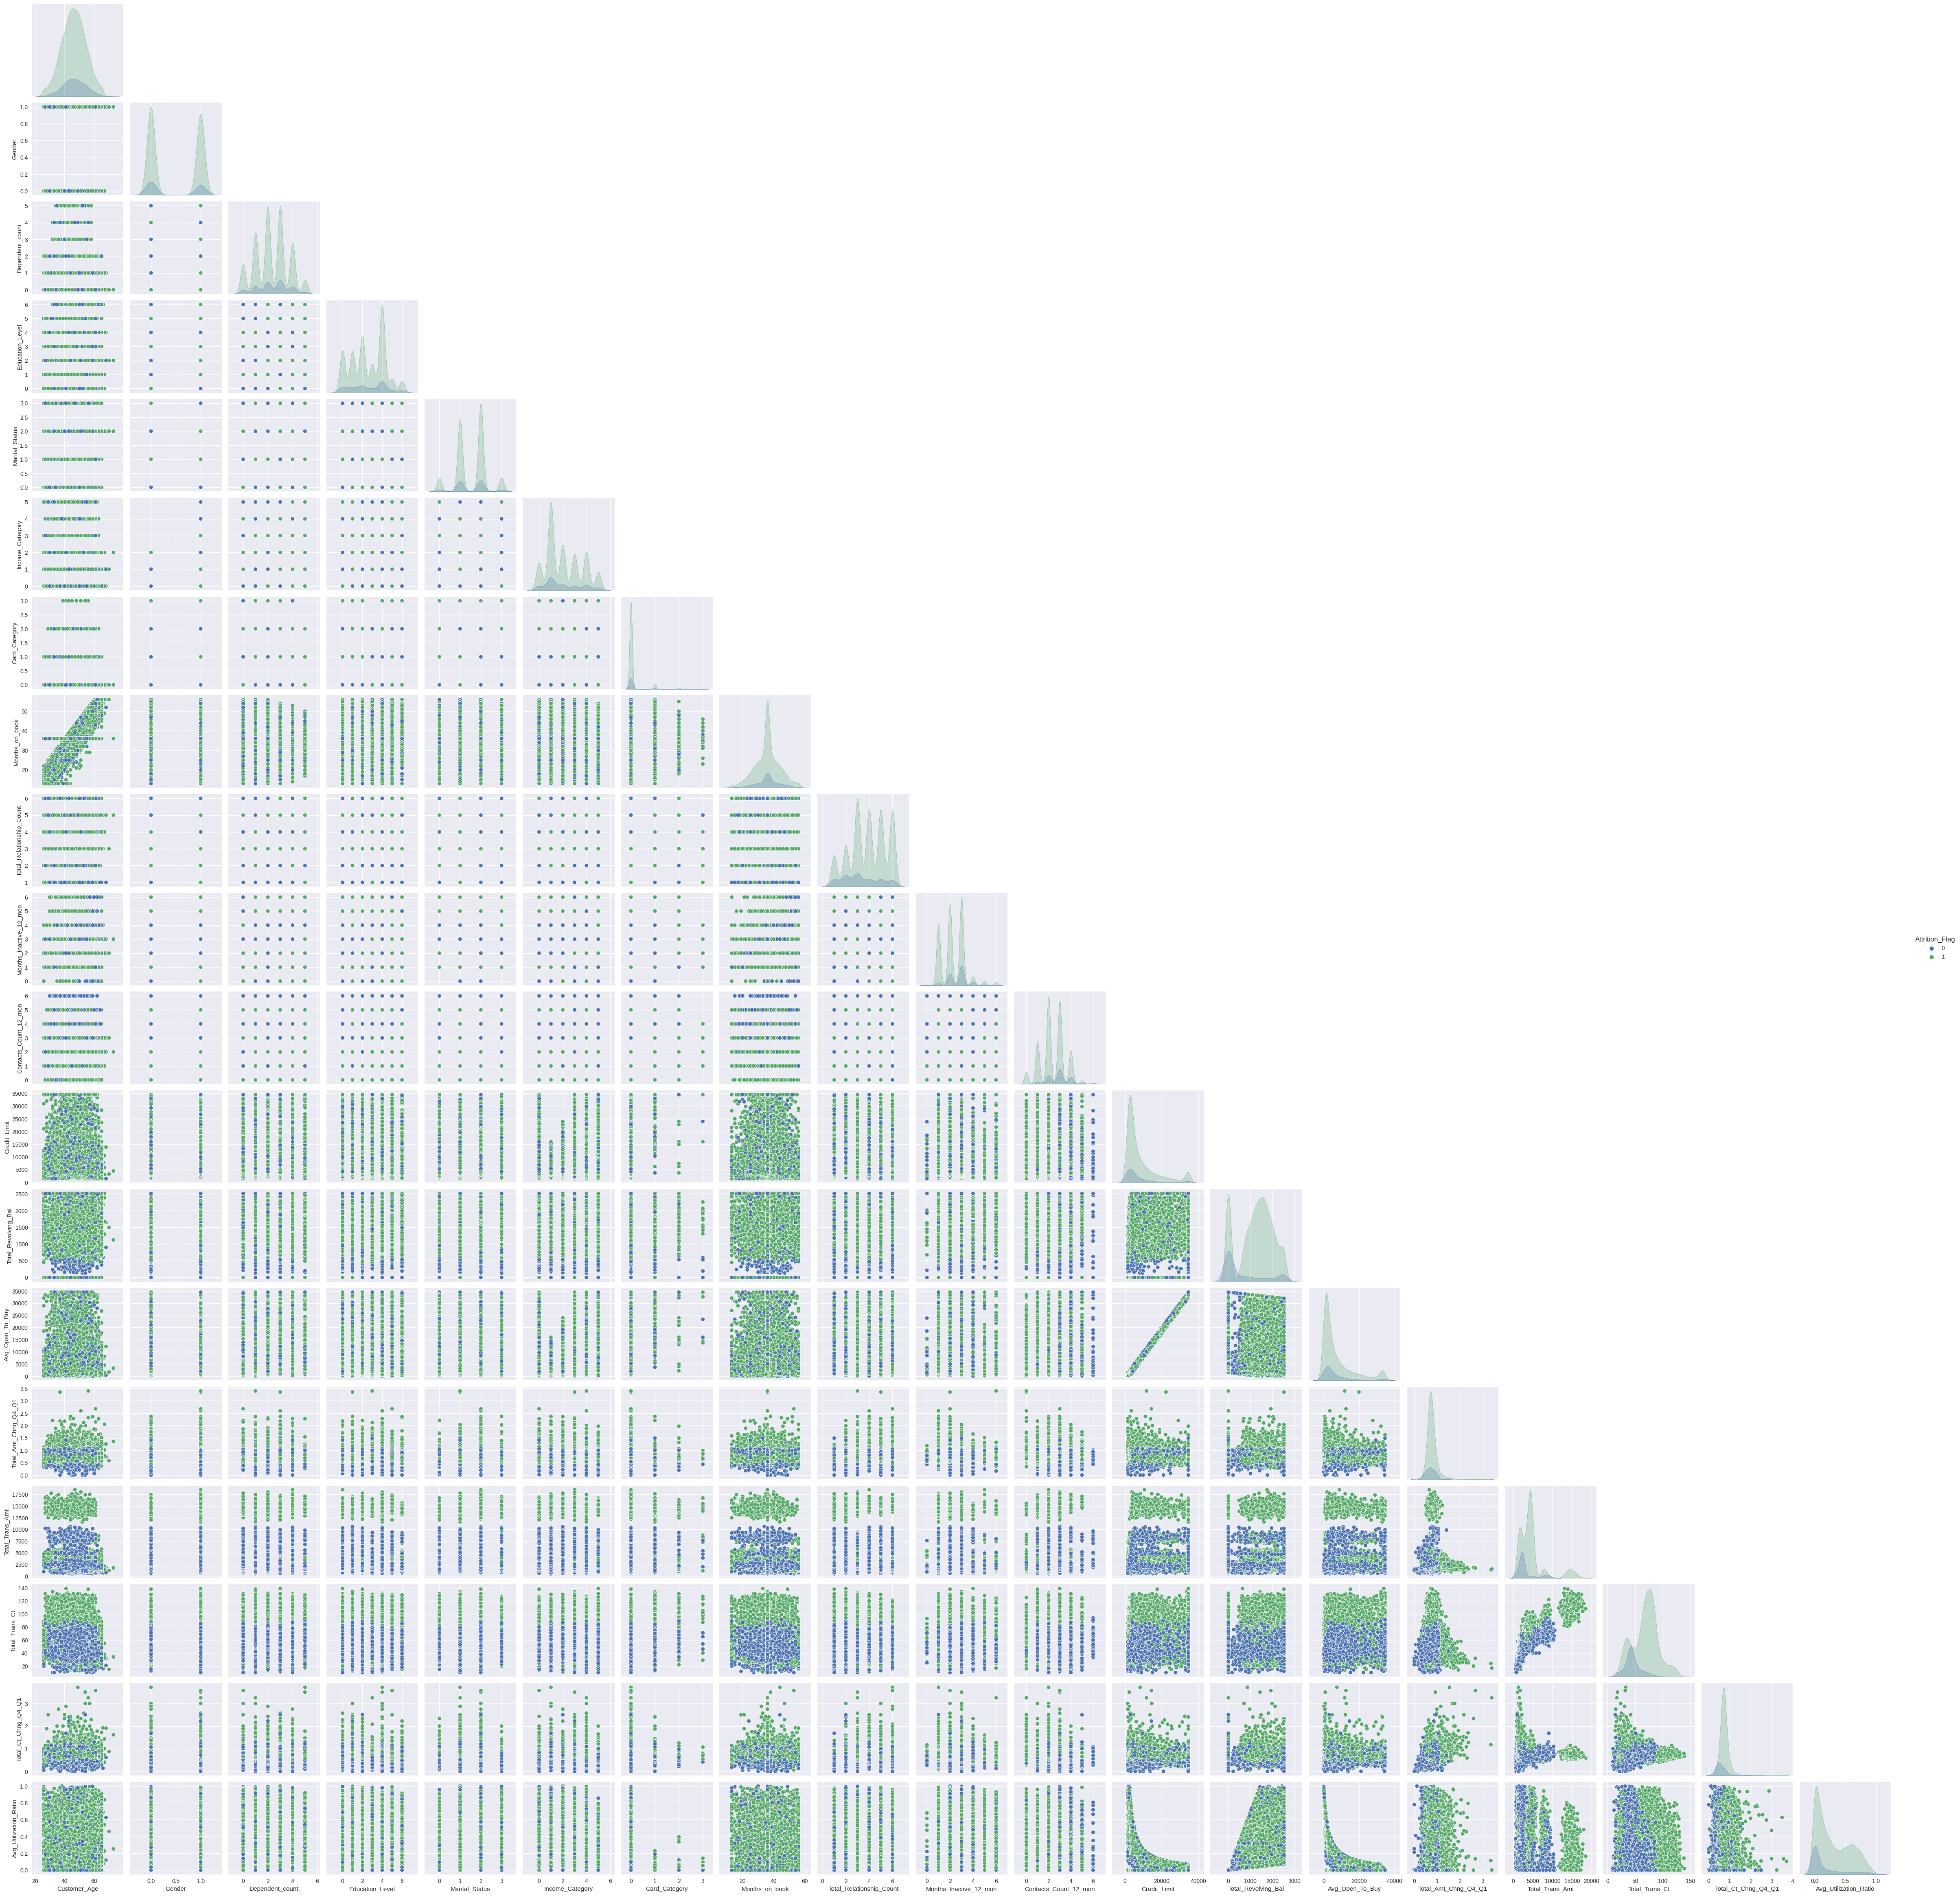

In [ ]:
sns.pairplot(df_filtered, hue='Attrition_Flag', corner=True, diag_kind='kde')

plt.show()

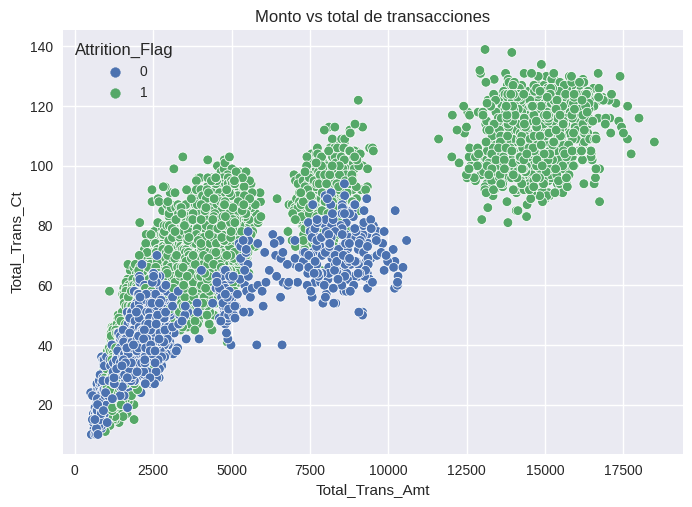

In [ ]:
sns.scatterplot(x='Total_Trans_Amt', y='Total_Trans_Ct', hue='Attrition_Flag', data=df_filtered)

plt.xlabel('Total_Trans_Amt')
plt.ylabel('Total_Trans_Ct')
plt.title('Monto vs total de transacciones')

plt.show()

## **3. Separación de datos**

#### 3.1 Entrenamiento y prueba

In [ ]:
x = df_filtered.drop(columns=['Attrition_Flag'])   #Si utilizamos todas las columnas obtenemos mejores resultados
# x = df_filtered[[
#     "Customer_Age",
#     "Gender",
#     "Dependent_count",
#     "Education_Level",
#     "Marital_Status",
#     "Income_Category",
#     "Credit_Limit",
#     "Total_Revolving_Bal",
#     "Total_Trans_Amt",
#     "Total_Trans_Ct"
# ]]                                                  # En este ejemplo solo utilizamos algunas columnas para simplificar la prueba final con joblib

y = df_filtered['Attrition_Flag']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3, shuffle=True, random_state= 42)

In [ ]:
train_value = y_train.value_counts()
test_value = y_test.value_counts()

print("Datos para entrenamiento en y_train: ", len(y_train))
print("Porcentaje de Clientes Existentes: ", "{:.2%}".format(train_value[1]/len(y_train)))
print("Porcentaje de Clientes Attrited: ", "{:.2%}".format(train_value[0]/len(y_train)))
print("\n")
print("Datos para prueba en y_test: ", len(y_test))
print("Porcentaje de Clientes Existentes: ", "{:.2%}".format(test_value[1]/len(y_test)))
print("Porcentaje de Clientes Attrited: ", "{:.2%}".format(test_value[0]/len(y_test)))


Datos para entrenamiento en y_train:  7088
Porcentaje de Clientes Existentes:  84.04%
Porcentaje de Clientes Attrited:  15.96%


Datos para prueba en y_test:  3039
Porcentaje de Clientes Existentes:  83.68%
Porcentaje de Clientes Attrited:  16.32%


## **4. Modelos de ML**



Para comparar los modelos seleccionados se utilizará:
- Reporte de clasificación <i>(Classification Report)</i>
- Matriz de Confusión
- Precision, Exactitud, Sensibilidad y Especificidad
- K-fold cross validation

> ### **4.1 LazyPredict**

In [ ]:
# Especifica los modelos deseados
desired_models = ['LGBMClassifier', 'RandomForestClassifier', 'DecisionTreeClassifier', 'GaussianNB']

# Crea una instancia de LazyClassifier solo con los modelos deseados
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

# Fit y predict con Lazy Classifier
models, predictions = clf.fit(x_train, x_test, y_train, y_test)

# Mostrar solo los resultados de los modelos seleccionados
selected_models = models.loc[desired_models]
selected_models

 97%|█████████▋| 28/29 [00:16<00:00,  2.59it/s]

[LightGBM] [Info] Number of positive: 5957, number of negative: 1131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2054
[LightGBM] [Info] Number of data points in the train set: 7088, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.840435 -> initscore=1.661465
[LightGBM] [Info] Start training from score 1.661465


100%|██████████| 29/29 [00:16<00:00,  1.72it/s]


Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                    
LGBMClassifier              0.97               0.94     0.94      0.97   
RandomForestClassifier      0.96               0.89     0.89      0.96   
DecisionTreeClassifier      0.93               0.86     0.86      0.93   
GaussianNB                  0.88               0.77     0.77      0.88   

                        Time Taken  
Model                               
LGBMClassifier                0.39  
RandomForestClassifier        1.41  
DecisionTreeClassifier        0.12  
GaussianNB                    0.03

In [ ]:
models

Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.97               0.94     0.94      0.97   
XGBClassifier                      0.96               0.93     0.93      0.96   
BaggingClassifier                  0.95               0.92     0.92      0.95   
AdaBoostClassifier                 0.95               0.90     0.90      0.95   
RandomForestClassifier             0.96               0.89     0.89      0.96   
DecisionTreeClassifier             0.93               0.86     0.86      0.93   
SVC                                0.93               0.82     0.82      0.92   
ExtraTreesClassifier               0.93               0.81     0.81      0.93   
QuadraticDiscriminantAnalysis      0.88               0.78     0.78      0.88   
GaussianNB                         0.88               0.77     0.77      0.88   
LinearDiscriminantAnalysis         0.90               0.77     0.77      0.89   
PassiveAggressiveClassifier        0.86               0.77     0.77      0.86   
NearestCentroid                    0.79               0.77     0.77      0.81   
LogisticRegression                 0.90               0.76     0.76      0.90   
CalibratedClassifierCV             0.90               0.76     0.76      0.89   
LinearSVC                          0.90               0.75     0.75      0.89   
SGDClassifier                      0.90               0.75     0.75      0.89   
LabelSpreading                     0.89               0.75     0.75      0.88   
LabelPropagation                   0.89               0.75     0.75      0.88   
KNeighborsClassifier               0.90               0.74     0.74      0.89   
ExtraTreeClassifier                0.86               0.74     0.74      0.86   
BernoulliNB                        0.87               0.73     0.73      0.87   
Perceptron                         0.87               0.72     0.72      0.87   
RidgeClassifierCV                  0.89               0.71     0.71      0.88   
RidgeClassifier                    0.89               0.71     0.71      0.88   
DummyClassifier                    0.84               0.50     0.50      0.76   

                               Time Taken  
Model                                      
LGBMClassifier                       0.39  
XGBClassifier                        0.28  
BaggingClassifier                    0.49  
AdaBoostClassifier                   0.62  
RandomForestClassifier               1.41  
DecisionTreeClassifier               0.12  
SVC                                  1.10  
ExtraTreesClassifier                 0.71  
QuadraticDiscriminantAnalysis        0.06  
GaussianNB                           0.03  
LinearDiscriminantAnalysis           0.12  
PassiveAggressiveClassifier          0.04  
NearestCentroid                      0.03  
LogisticRegression                   0.06  
CalibratedClassifierCV               1.83  
LinearSVC                            0.51  
SGDClassifier                        0.10  
LabelSpreading                       4.29  
LabelPropagation                     4.01  
KNeighborsClassifier                 0.31  
ExtraTreeClassifier                  0.03  
BernoulliNB                          0.04  
Perceptron                           0.04  
RidgeClassifierCV                    0.07  
RidgeClassifier                      0.04  
DummyClassifier                      0.02

> ### **4.2 Modelo I: Naïve Bayes** (clasificación)


In [ ]:
# Crear y entrenar el modelo Naive Bayes
NaiveBayes = GaussianNB()
NaiveBayes.fit(x_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_Bayes = NaiveBayes.predict(x_test)

# Imprimir la matriz de confusión y el informe de clasificación
print("Matriz de Confusión:\n", confusion_matrix(y_test, y_pred_Bayes))
print("\nInforme de Clasificación:\n", classification_report(y_test, y_pred_Bayes))

Matriz de Confusión:
 [[ 291  205]
 [ 146 2397]]

Informe de Clasificación:
               precision    recall  f1-score   support

           0       0.67      0.59      0.62       496
           1       0.92      0.94      0.93      2543

    accuracy                           0.88      3039
   macro avg       0.79      0.76      0.78      3039
weighted avg       0.88      0.88      0.88      3039



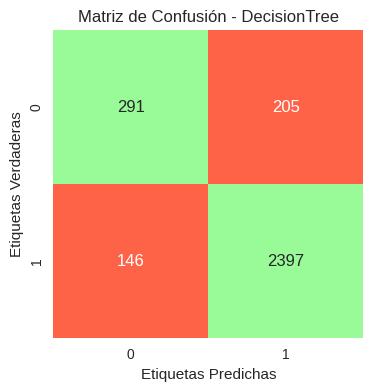

In [ ]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred_Bayes)
fig, ax = plt.subplots(figsize=(4, 4))

# Crear un mapa de calor (heatmap) con la matriz de confusión, cantidad y porcentaje
sns.heatmap(np.eye(2), annot=cm, fmt='g',
            cmap=sns.color_palette(['tomato', 'palegreen'], as_cmap=True), cbar=False,
            yticklabels=['0', '1'], xticklabels=['0', '1'], ax=ax)

# Configurar etiquetas y títulos
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Verdaderas')
plt.title('Matriz de Confusión - DecisionTree')

# Mostrar la matriz de confusión
plt.show()

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_Bayes)

tn, fp, fn, tp = cnf_matrix.ravel()

print("Precision:",metrics.precision_score(y_test, y_pred_Bayes))
print("Exactitud:",metrics.accuracy_score(y_test, y_pred_Bayes))
print("Sensibilidad:",metrics.recall_score(y_test, y_pred_Bayes))
print("Especificidad:", tn / (tn + fp))

Precision: 0.9212144504227517
Exactitud: 0.8845014807502468
Sensibilidad: 0.9425874950845458
Especificidad: 0.5866935483870968


In [ ]:
# k-fold

scores = cross_val_score(NaiveBayes, x, y, cv=KFold(n_splits=10), scoring="accuracy")

print("Metricas cross_validation", scores)

print("Media de cross_validation", scores.mean())


Metricas cross_validation [0.78775913 0.71668312 0.85093781 0.92596249 0.93583416 0.92793682
 0.92596249 0.93577075 0.9298419  0.75296443]
Media de cross_validation 0.8689653086944815


> ### **4.3 Modelo II: Árbol de decisión** (clasificación)


In [ ]:
# Crear y entrenar el modelo de árbol de decisión
dtree = DecisionTreeClassifier()
dtree.fit(x_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_tree = dtree.predict(x_test)

# Imprimir la matriz de confusión y el informe de clasificación
print("Matriz de Confusión:\n", confusion_matrix(y_test, y_pred_tree))
print("\nInforme de Clasificación:\n", classification_report(y_test, y_pred_tree))

Matriz de Confusión:
 [[ 387  109]
 [ 103 2440]]

Informe de Clasificación:
               precision    recall  f1-score   support

           0       0.79      0.78      0.78       496
           1       0.96      0.96      0.96      2543

    accuracy                           0.93      3039
   macro avg       0.87      0.87      0.87      3039
weighted avg       0.93      0.93      0.93      3039



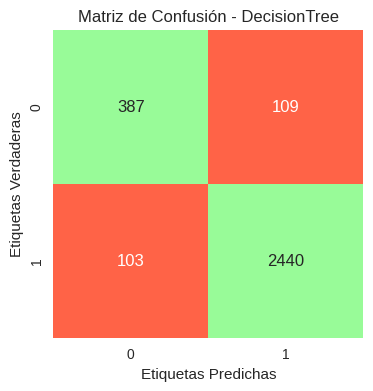

In [ ]:


# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred_tree)
fig, ax = plt.subplots(figsize=(4, 4))

# Crear un mapa de calor (heatmap) con la matriz de confusión, cantidad y porcentaje
sns.heatmap(np.eye(2), annot=cm, fmt='g',
            cmap=sns.color_palette(['tomato', 'palegreen'], as_cmap=True), cbar=False,
            yticklabels=['0', '1'], xticklabels=['0', '1'], ax=ax)

# Configurar etiquetas y títulos
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Verdaderas')
plt.title('Matriz de Confusión - DecisionTree')

# Mostrar la matriz de confusión
plt.show()

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_tree)

tn, fp, fn, tp = cnf_matrix.ravel()

print("Precision:",metrics.precision_score(y_test, y_pred_tree))
print("Exactitud:",metrics.accuracy_score(y_test, y_pred_tree))
print("Sensibilidad:",metrics.recall_score(y_test, y_pred_tree))
print("Especificidad:", tn / (tn + fp))

Precision: 0.95723813260102
Exactitud: 0.9302402105955907
Sensibilidad: 0.9594966574911522
Especificidad: 0.780241935483871


In [ ]:
# k-fold
scores = cross_val_score(dtree, x, y, cv=KFold(n_splits=10), scoring="accuracy")

print("Metricas cross_validation", scores)

print("Media de cross_validation", scores.mean())

Metricas cross_validation [0.84797631 0.87660415 0.89733465 0.92694965 0.94373149 0.95261599
 0.94570582 0.95454545 0.78162055 0.79347826]
Media de cross_validation 0.8920562333927714



> ### **4.4 Modelo III: Random Forest** (clasificación)


In [ ]:
# Crear y entrenar el modelo de Random Forest
rfc = RandomForestClassifier(n_estimators=400, max_depth = 15, random_state=42)
rfc.fit(x_train, y_train)

# Imprimir la matriz de confusión y el informe de clasificación
y_pred_Forest = rfc.predict(x_test)
print("Matriz de Confusión:\n", confusion_matrix(y_test, y_pred_Forest))
print("\nInforme de Clasificación:\n", classification_report(y_test, y_pred_Forest))

Matriz de Confusión:
 [[ 404   92]
 [  26 2517]]

Informe de Clasificación:
               precision    recall  f1-score   support

           0       0.94      0.81      0.87       496
           1       0.96      0.99      0.98      2543

    accuracy                           0.96      3039
   macro avg       0.95      0.90      0.92      3039
weighted avg       0.96      0.96      0.96      3039



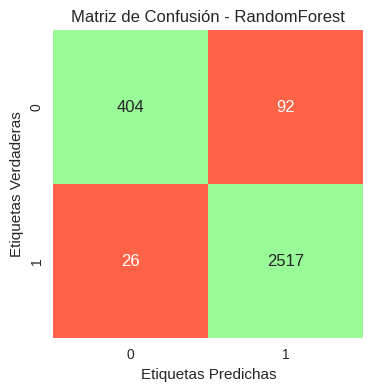

In [ ]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred_Forest)
fig, ax = plt.subplots(figsize=(4, 4))

# Crear un mapa de calor (heatmap) con la matriz de confusión, cantidad y porcentaje
sns.heatmap(np.eye(2), annot=cm, fmt='g',
            cmap=sns.color_palette(['tomato', 'palegreen'], as_cmap=True), cbar=False,
            yticklabels=['0', '1'], xticklabels=['0', '1'], ax=ax)

# Configurar etiquetas y títulos
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Verdaderas')
plt.title('Matriz de Confusión - RandomForest')

# Mostrar la matriz de confusión
plt.show()

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_Forest)

tn, fp, fn, tp = cnf_matrix.ravel()

print("Precision:",metrics.precision_score(y_test, y_pred_Forest))
print("Exactitud:",metrics.accuracy_score(y_test, y_pred_Forest))
print("Sensibilidad:",metrics.recall_score(y_test, y_pred_Forest))
print("Especificidad:", tn / (tn + fp))

Precision: 0.9647374472978153
Exactitud: 0.9611714379730174
Sensibilidad: 0.9897758552890287
Especificidad: 0.8145161290322581


In [ ]:
# k-fold

scores = cross_val_score(rfc, x, y, cv=KFold(n_splits=10), scoring="accuracy")

print("Metricas cross_validation", scores)

print("Media de cross_validation", scores.mean())


Metricas cross_validation [0.90325765 0.93484699 0.95755183 0.95952616 0.96742349 0.96544916
 0.95360316 0.97134387 0.9041502  0.77075099]
Media de cross_validation 0.9287903499564945


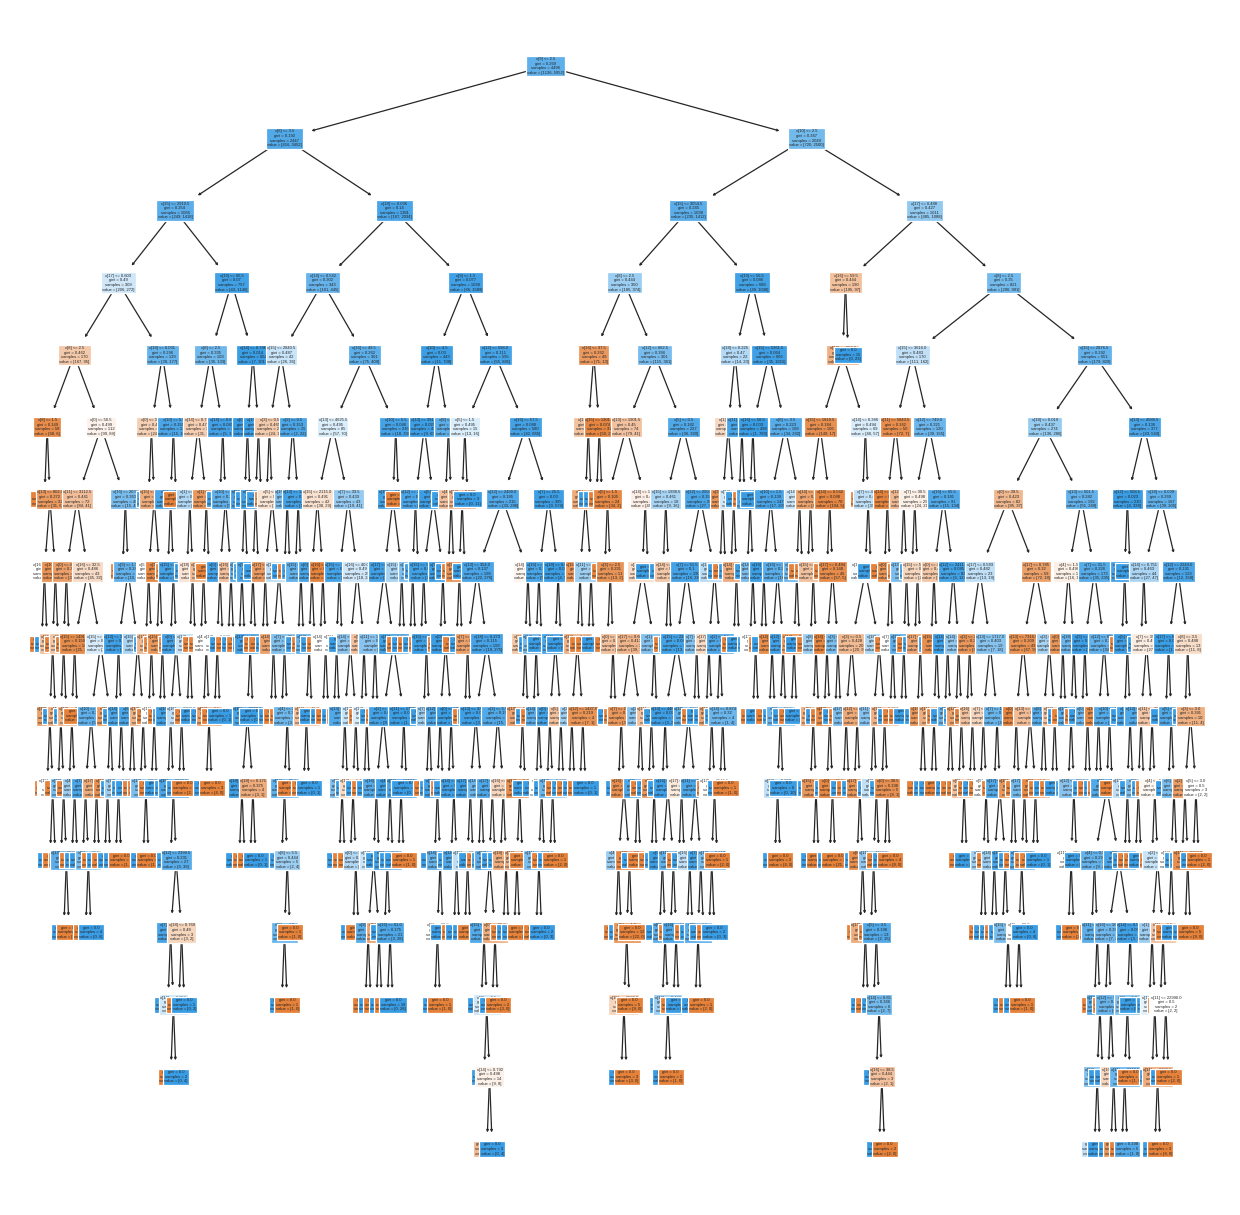

In [ ]:
#Sientete libre de elegir alguno de los arboles:
numeroArbol = 26
arbolDelBosque = rfc.estimators_[numeroArbol]

plt.figure(figsize = (5,5), dpi = 300)
treeClassifier.plot_tree(arbolDelBosque,filled = True);
plt.show()

> ### **4.5 Modelo IV: Light GBM**
El mejor modelo segun LazyPredict es LightGBM

LightGBM es un algoritmo de refuerzo (o también de potenciación) de gradientes (gradient boosting) basado en modelos de árboles de decisión. Puede ser utilizado para la categorización, clasificación y muchas otras tareas de aprendizaje automático, en las que es necesario maximizar o minimizar una función objetivo mediante la técnica de gradient boosting, que consiste en combinar clasificadores sencillos, como por ejemplo árboles de decisión de profundidad limitada.

Entre sus principales ventajas podemos destacar las siguientes:

* Mayor velocidad de entrenamiento y mayor eficiencia
* Menor uso de memoria
* Mayor precisión
* Soporte de aprendizaje paralelo y soporte para GPUs
* Capacidad para manejar datos a gran escala

In [ ]:
# Crear y entrenar el modelo LGBMClassifier
lgb = LGBMClassifier(learning_rate=0.01, max_depth=7, min_child_weight=3,
                     n_estimators=2000, num_leaves=5)
lgb.fit(x_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_lgb = lgb.predict(x_test)

# Calcular la matriz de confusión y el informe de clasificación
conf_matrix = confusion_matrix(y_test, y_pred_lgb)
classification_rep = classification_report(y_test, y_pred_lgb)

# Imprimir la matriz de confusión y el informe de clasificación
print("\n")
print("Matriz de Confusión:\n", conf_matrix)
print("\nInforme de Clasificación:\n", classification_rep)


[LightGBM] [Info] Number of positive: 5957, number of negative: 1131
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2046
[LightGBM] [Info] Number of data points in the train set: 7088, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.840435 -> initscore=1.661465
[LightGBM] [Info] Start training from score 1.661465


Matriz de Confusión:
 [[ 436   60]
 [  35 2508]]

Informe de Clasificación:
               precision    recall  f1-score   support

           0       0.93      0.88      0.90       496
           1       0.98      0.99      0.98      2543

    accuracy                           0.97      3039
   macro avg       0.95      0.93      0.94      3039
weighted avg       0.97      0.97      0.97      3039



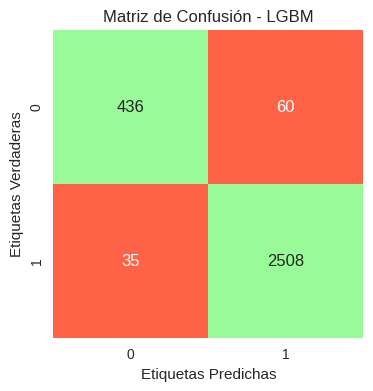

In [ ]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred_lgb)
fig, ax = plt.subplots(figsize=(4, 4))

# Crear un mapa de calor (heatmap) con la matriz de confusión, cantidad y porcentaje
sns.heatmap(np.eye(2), annot=cm, fmt='g',
            cmap=sns.color_palette(['tomato', 'palegreen'], as_cmap=True), cbar=False,
            yticklabels=['0', '1'], xticklabels=['0', '1'], ax=ax)

# Configurar etiquetas y títulos
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Verdaderas')
plt.title('Matriz de Confusión - LGBM')

# Mostrar la matriz de confusión
plt.show()

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_lgb)

tn, fp, fn, tp = cnf_matrix.ravel()

print("Precision:",metrics.precision_score(y_test, y_pred_lgb))
print("Exactitud:",metrics.accuracy_score(y_test, y_pred_lgb))
print("Sensibilidad:",metrics.recall_score(y_test, y_pred_lgb))
print("Especificidad:", tn / (tn + fp))

Precision: 0.9766355140186916
Exactitud: 0.9687397170121751
Sensibilidad: 0.9862367282736925
Especificidad: 0.8790322580645161


In [ ]:
# k-fold

scores = cross_val_score(lgb, x, y, cv=KFold(n_splits=10), scoring="accuracy")

print("Metricas cross_validation", scores)

print("Media de cross_validation", scores.mean())

[LightGBM] [Info] Number of positive: 7590, number of negative: 1524
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2042
[LightGBM] [Info] Number of data points in the train set: 9114, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.832785 -> initscore=1.605493
[LightGBM] [Info] Start training from score 1.605493
[LightGBM] [Info] Number of positive: 7557, number of negative: 1557
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 9114, number of used features: 19
[LightGBM] [Info] [b

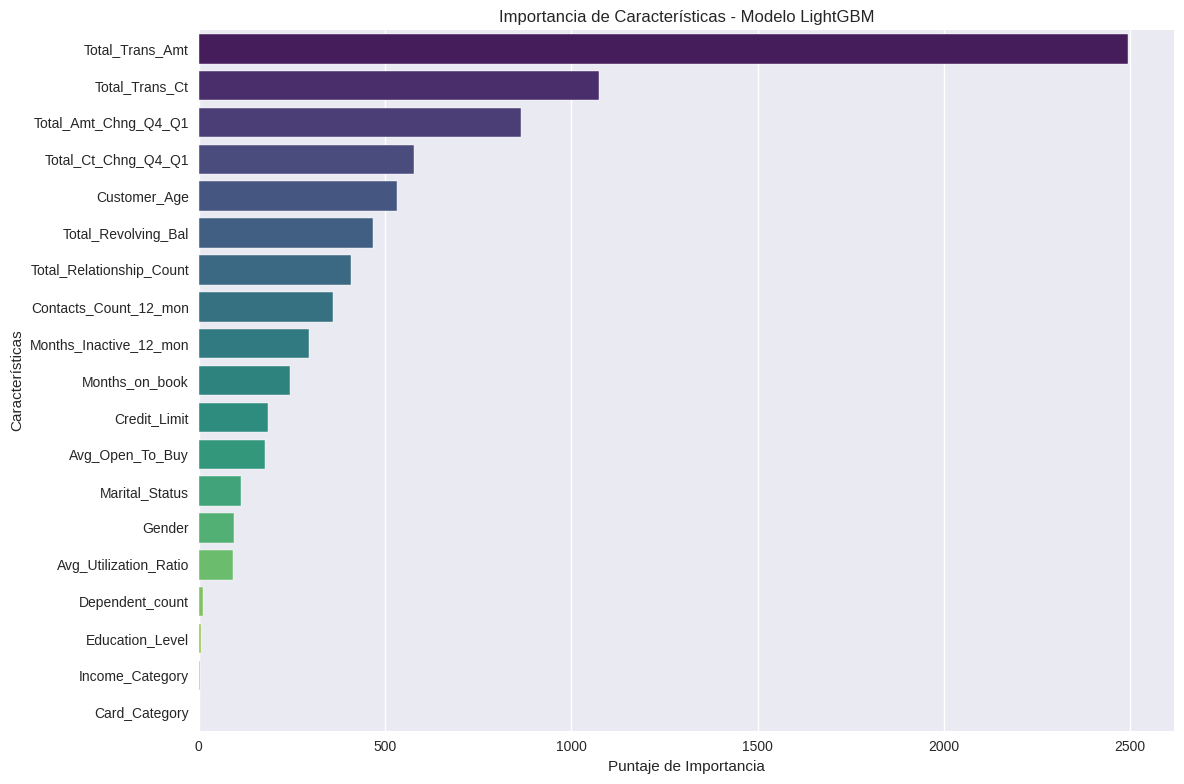

In [ ]:
# Crear el DataFrame con las características importantes y ordenarlo por valor
feature_imp = pd.DataFrame(sorted(zip(lgb.feature_importances_, x.columns), reverse=True), columns=['Value', 'Feature'])

# Configurar el tamaño de la figura
plt.figure(figsize=(12, 8))

# Crear un gráfico de barras horizontal
sns.barplot(x="Value", y="Feature", data=feature_imp, palette="viridis")

# Configurar etiquetas y título
plt.xlabel('Puntaje de Importancia')
plt.ylabel('Características')
plt.title('Importancia de Características - Modelo LightGBM')

# Ajustar el tamaño de fuente en los ejes x e y
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Ajustar el diseño de la figura
plt.tight_layout()

# Mostrar el gráfico
plt.show()


Nota: se realizaron varios experimentos con estos modelos y el uso de todas o algunas variables para entrenarlos. Se encontró que el usar menos variables afectaba el desempeño de los modelos. La gráfica de barras muestra la importancia de cada variable en el desempeño del último modelo (se obtuvieron gráficas similares con los demás). Para futuros trabajos con más cantidades de datos se sugiere elegir el top 10 para disminuir los tiempos y poder computacional requerido para el uso de estos modelos. (principalmente random forest, que es el modelo que más recursos utiliza para su ejecución.)


## **5. Usar el modelo para hacer predicciones sobre nuevos datos**

> ### **5.1 Guardar el modelo**

Hemos probado diferentes modelos y ahora tenemos el mejor. Es hora de guardarlo para que podamos usarlo en cualquier momento sin tener que recrearlo.

In [ ]:
import joblib

filename = 'final_model.sav'
joblib.dump(lgb, filename)

['final_model.sav']

> ### **5.2 Cargar el modelo**

Cargar un modelo guardado previamente.

In [ ]:
filename = 'final_model.sav'
loaded_model = joblib.load(filename)

> ### **5.3 Utilizar el modelo para predecir**

Utilizar el modelo para predecir la variable Atrittion_Flag con nuevos clientes

NOTA: falta en todos los modelos utilizar solo unas cuantas variables para el entrenamiento de modo que al llegar a esta parte cargamos los datos de nuevos clientes para predecir si son propensos a abandonar o a seguir con el servicio.

In [ ]:
# Crear un DataFrame con las nuevas características
new_features = {
    "Customer_Age": [50],
    "Gender": [1],            # ['F', 'M'] - [0, 1]
    "Dependent_count": [2],
    "Education_Level": [4],   # ['Unknown', 'Uneducated', 'High School', 'College', 'Graduate', 'Post-Graduate', 'Doctorate'] - [0, 1, 2, 3, 4, 5, 6]"
    "Marital_Status": [1],    # ['Unknown', 'Single', 'Married', 'Divorced'] - [0, 1, 2, 3]"
    "Income_Category": [4],   # 'Unknown': 0, 'Less than $40K': 1, '$40K - $60K': 2, '$60K - $80K': 3, '$80K - $120K': 4, '$120K +': 5
    "Credit_Limit": [2000],
    "Total_Revolving_Bal": [200],
    "Total_Trans_Amt": [2000],
    "Total_Trans_Ct": [200],
}

new_customer = pd.DataFrame(new_features)

# Realizar predicciones usando el modelo LGBMClassifier previamente entrenado
y_pred_new_customer = lgb.predict(new_customer)

# Imprimir las predicciones
print("Prediccion para el nuevo cliente:", y_pred_new_customer)

#Utiliza el modelo para predecir la etiqueta del cliente
if y_pred_new_customer == 1:
    print("Existing Customer")
else:
    print("Attrited Customer")

Prediccion para el nuevo cliente: [1]
Existing Customer


## 6. Conclusiones

- Las inferencias que realizamos del análisis exploratorio de datos respecto a qué variables utilizar en los modelos, sirvió para comprender el problema que estábamos atacando. Empero, al final después de experimentar con los modelos se decidió utilizar todas las variables porque así se obtenían mejores resultados con los modelos.
- Se incentiva el uso de LazyPredict y de otras herramientas similares para trabajos a futuro con el fin de agilizar la toma de decisión sobre qué modelos implementar en problemas de clasificación (y también predicción). Ya que esto al final corroboró lo que ya teníamos avanzado del proyecto, pero utilizarlo al inicio hubiera sido de mayor ventaja en cuestión de tiempos.
- Los modelos de clasificación supervisada, utilizados en este proyecto mostraron tener ventajas y mejoras entre sí.
- Entre el modelo RainForest y LGBM se concluye que tienen desempeños muy similares. RainForest es mejor para evitar overfitting ya que si logró predecir de buena manera con datos nuevos (cross-validation). Por el contrario, LGBM es mejor en cuestión de tiempo de ejecución.
- Los cuatro modelos utilizados sirven para resolver el problema planteado. Con ellos pudimos determinar si un cliente sigue vigente en el banco o, de lo contrario, si ya canceló su tarjeta de crédito.


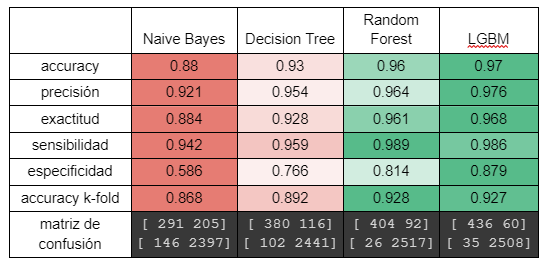

## 7. Trabajo futuro

Para poder resolver el problema original, que es predecir si los clientes seguiran con el banco o abandonaran, se plantea el uso de un `Random Forest Regressor`. Con este modelo se podra obtener una salida binaria, que indicara esa toma de decisión del si o no quedarse por medio de un porcentaje probabilistico.